In [ ]:
# default_exp modeling.text_generation

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# modeling.text_generation

> This module contains custom models, loss functions, custom splitters, etc... for token classification tasks like summarization.

In [ ]:
#export
import ast, torch
from transformers import *
from fastai2.text.all import *

from blurr.data.all import *
from blurr.modeling.core import *

In [ ]:
#hide
import pdb

from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## Text generation

The objective of text generation is to create reasonable textual responses given a prior piece of input.  For example, we may want to summarize an article in a single sentence or have a chatbot provide a sensible response to a question.

In [ ]:
path = Path('./')
cnndm_df = pd.read_csv(path/'cnndm_sample.csv'); len(cnndm_df)

1000

In [ ]:
cnndm_df.head(2)

,article,highlights,ds_type
0,"(CNN) -- Globalization washes like a flood over the world's cultures and economies. Floods can be destructive; however, they can also bring blessings, as the annual floods of the Nile did for ancient Egypt. The world's great universities can be crucial instruments in shaping, in a positive way, humankind's reaction to globalization and the development of humankind itself. Traditionally, universities have been defined and limited by location, creating an academic community and drawing students and scholars to that place. Eventually, some universities began to encourage students to study el...","John Sexton: Traditionally, universities have been defined and limited by location .\nGlobal campuses form a network of thought, innovation, he writes .\nFaculty can teach, Sexton says, students can team up in many cities at once .\nSexton: Research, scholarship can be shared and cultural ties made in ""century of knowledge""",train
1,"(CNN) -- Armenian President Robert Kocharian declared a state of emergency Saturday night after a day of clashes between police and protesters, a spokeswoman for the Armenian Foreign Ministry said. Opposition supporters wave an Armenian flag during a protest rally in Yerevan, Armenia, on Saturday. The protesters claim last month's presidential election was rigged. The state of emergency will ""hopefully bring some order"" to the capital, Yerevan, said Salpi Ghazarian, assistant to the Armenian foreign minister, who spoke to CNN early Sunday. The state of emergency could last until March 20, ...","NEW: Protest moves after crackdown at Freedom Square .\nOrder sought after protests over last month's election turn violent .\nDemonstrators say the election was fraudulent .\nState of emergency could last until March 20, official says .",train


In [ ]:
pretrained_model_name = "facebook/bart-large-cnn"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               model_cls=BartForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

Some weights of BartForConditionalGeneration were not initialized from the model checkpoint at facebook/bart-large-cnn and are newly initialized: ['final_logits_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


('bart',
 transformers.configuration_bart.BartConfig,
 transformers.tokenization_bart.BartTokenizer,
 transformers.modeling_bart.BartForConditionalGeneration)

In [ ]:
hf_batch_tfm = HF_TextGenerationBatchTransform(hf_arch, hf_tokenizer)

blocks = ( 
    HF_TextBlock(hf_arch, hf_tokenizer), 
    HF_TextBlock(hf_arch, hf_tokenizer, hf_batch_tfm=hf_batch_tfm, max_length=150)
)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('article'), 
                   get_y=ColReader('highlights'), 
                   splitter=RandomSplitter())

In [ ]:
dls = dblock.dataloaders(cnndm_df, bs=4)

In [ ]:
b = dls.one_batch()

In [ ]:
# len(b), b[0]['input_ids'].shape, b[1].shape

In [ ]:
dls.show_batch(hf_tokenizer=hf_tokenizer, max_n=2)

,text,target
0,"(CNN) -- A suspect is in custody about an hour after one person was shot late Monday morning on the campus of Middle Tennessee State University, a school spokesman said. Officials called off a lockdown, which had been in effect as SWAT teams and other law enforcement authorities converged on the campus, after the suspect was detained about 12:45 p.m., said the university's media relations director, Tom Tozer. A gun said to have been used in the incident has also been confiscated. Authorities were alerted at 11:51 a.m. about a shooting in a basic and applied science building located in a cluster of university structures. ""From what I understand, there were two men who got into an argument over by some of our buildings,"" Tozer said. ""One shot the other in the hand, then took off."" The victim, whose condition was not immediately known, was taken to a nearby medical facility. Tozer said he cannot confirm whether those involved were students. Meanwhile, police began hunting for the shooter on 25,000-student university's campus, in the central Tennessee city of Murfreesboro. Firearms are not allowed on campus, per school policy, according to Tozer. The spokesman said that officials believe the situation is now under control. ""We are advising people to proceed with caution with normal activities today,"" Tozer said.","NEW: A shooting suspect is arrested at Middle Tennessee State, a spokesman says.\nNEW: The lockdown at the school has been called off, and have police confiscated a gun.\nNEW: The victim was shot in the hand and brought to a local hospital, the spokesman says."
1,"(CNN) -- ""Black Dynamite"" has a new lease on life. This time around, the hero of the 2009 film that lampooned blaxploitation movies is in animated form in a new series on Cartoon Network's Adult Swim program block. Some of the actors from the film will reprise their roles, but there will be changes as well. The movie, which enjoyed only a two-week theatrical release despite premiering at the Sundance Film Festival, was deliberately cheesy. To parody the cheap, hastily produced blaxploitation films, ""Black Dynamite"" actors intentionally chewed up scenery or performed awkwardly. There were telltale signs of a second-rate production, such as the appearance of a boom mike. The new ""Black Dynamite"" is still set in the 1970s, but the 10-episode cartoon series is more like ""Shaft"" than a sendup of blaxpoitation, said Michael Jai White, who supplies Black Dynamite's voice and serves as a producer. As in the film, the polyester pants suit-garbed Black Dynamite is a former CIA agent, a lover and a kung fu fighter. He has returned to the 'hood to combat evil and protect the children in the Whorephanage, who are looked after by the working girls and their boss, sexy no-nonsense Honey Bee (Kym Whitley). ""The characters have to be a little bigger than life, but it's a fun challenge, and the essence of the characters is still there,"" said Carl Jones, former executive producer of ""The Boondocks"" on Adult Swim, who serves as the director and an executive producer for ""Black Dynamite."" ""Obviously, with a cartoon, you can do more things than you can do in live action,"" Jones said. ""It opens a lot more doors for us to explore different characters and genres."" In one episode, Black Dynamite is hired to make sure comedian Richard Pryor shows up for a scheduled performance. In the story, Pryor is distraught because audiences automatically laugh at him, making it hard to offer serious social commentary. ""I wanted to take another perspective on Richard as a human being,"" Jones said. ""Richard never wanted to be funny. He had something to say. He was a storyteller. He was a teacher to me."" In another episode, a parody of ""King Kong,"" Black Dynamite goes after an albino ape that scaled the iconic Watts Towers in Los Angeles. White said","""Black Dynamite"" film lampooned black exploitation films.\nThe movie has been made into an animated serie

In additiont to updating our model wrapper to allow us to include `decoder_input_ids`, below we add a custom param splitter to give us a bit more depth in applying discriminative learning rates.

In [ ]:
#export
def text_gen_splitter(m, arch):
    """Custom param splitter for text generation models"""
    model = m.hf_model if (hasattr(m, 'hf_model')) else m
    
    if (arch == 'bart'):     
        embeds = nn.Sequential(
            model.model.shared, 
            model.model.encoder.embed_positions, 
            model.model.encoder.embed_tokens,
            model.model.decoder.embed_positions, 
            model.model.decoder.embed_tokens
        )
        
        groups = L(embeds, model.model.encoder, model.model.decoder)
        return groups.map(params).filter(lambda el: len(el) > 0)
    
    raise ValueError('Invalid architecture')

In [ ]:
show_doc(text_gen_splitter)

<h4 id="text_gen_splitter" class="doc_header"><code>text_gen_splitter</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>text_gen_splitter</code>(**`m`**, **`arch`**)

Custom param splitter for text generation models

In [ ]:
#export
class HF_TextGenModelCallback(HF_BaseModelCallback):  
    def after_pred(self): 
        if ('labels' in self.xb[0]):
            self.hf_loss, self.learn.pred = self.pred[0], self.pred[1]
        else:
            self.learn.pred = self.pred[0]
            
    def after_loss(self): self.learn.loss = self.hf_loss

Since these huggingface transformers return the loss if when we are training, and pass in both `labels` and `decoder_input_ids` in the input, we use the callback above to capture it and then set `self.learn.loss` to it *prior* to the backward pass by overriding `after_loss`.

As a loss function is therefore not required by our `Learner`, we can set it to `noop` as we do below.

In [ ]:
#export
class HF_MaskedLMLoss():
    def __call__(self, inp, targ, **kwargs): return
    def decodes(self, x): return x.argmax(dim=-1)
    def activation(self, x): return F.softmax(x, dim=-1)

In [ ]:
model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=ranger,
                loss_func=HF_MaskedLMLoss(),
                cbs=[HF_TextGenModelCallback],
                splitter=partial(text_gen_splitter, arch=hf_arch))#.to_fp16()

learn.create_opt() 
learn.freeze()

In [ ]:
# learn.blurr_summary()

In [ ]:
b = dls.one_batch()
preds = learn.model(b[0])
len(preds),preds[0], preds[1].shape

(3,
 tensor(3.4374, device='cuda:1', grad_fn=<NllLossBackward>),
 torch.Size([4, 149, 50264]))

In [ ]:
len(b), len(b[0]), b[0]['input_ids'].shape, len(b[1]), b[1].shape

(2, 4, torch.Size([4, 512]), 4, torch.Size([4, 150]))

In [ ]:
print(len(learn.opt.param_groups))

3


SuggestedLRs(lr_min=0.00036307806149125097, lr_steep=7.585775892948732e-05)

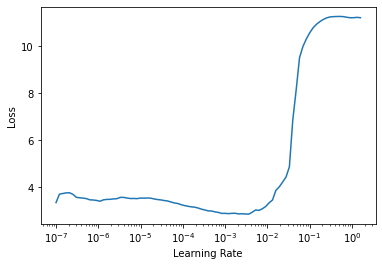

In [ ]:
#slow
learn.lr_find(suggestions=True)

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max=3e-5)

epoch,train_loss,valid_loss,time
0,1.710728,1.677107,01:16
1,1.236011,1.661432,01:17
2,1.170942,1.657546,01:17


In [ ]:
#export
@typedispatch
def show_results(x:HF_TextGenerationInput, y, samples, outs, hf_tokenizer, generated_max_len=130, 
                 ctxs=None, max_n=6, **kwargs):  
    
    res = L([ (sample[0], sample[1], pred[0].replace(hf_tokenizer.pad_token, '')[:generated_max_len]) 
             for sample, pred in zip(samples, outs) ])          
    
    display_df(pd.DataFrame(res, columns=['text', 'target', 'prediction'])[:max_n])
    return ctxs

In [ ]:
learn.show_results(hf_tokenizer=hf_tokenizer, max_n=2)

,text,target,prediction
0,"RIO DE JANEIRO, Brazil (CNN) -- Former presidents of Mexico, Colombia and Brazil called Wednesday for the decriminalization of marijuana for personal use and a change in tactics on the war on drugs, a Spanish news agency said. People march in support of legalized marijuana in late January in Belem, northern Brazil. Ex-presidents Ernesto Zedillo of Mexico, Cesar Gaviria of Colombia and Fernando Henrique Cardoso of Brazil made their announcement at a meeting in Brazil of the Latin American Commission on Drugs and Democracy, the EFE news agency said. ""The problem is that current policies are based on prejudices and fears and not on results,"" Gaviria said at a news conference in which the commission's recommendations were presented. The 17-member panel worked on the report for a year and will forward it to all Latin American governments as well as the United States and the European Union, EFE said. Gaviria said the time is right to start a debate on the subject, particularly with the pragmatic openings provided by the election of President Barack Obama in the United States. ""In many states in the United States, as is the case in California, they have begun to change federal policies with regard to tolerating marijuana for therapeutic purposes. And in Washington there's some consensus that the current policy is failing,"" EFE quotes Gaviria as saying. Decriminalization should be accompanied by treatment for addicts and public service campaigns on abuse prevention, the commission said. ""If you don't help those who are dependent, you are half way there because they are going to commit crime to get money and pay for the drug,"" Gaviria said. Cardoso said the group called for only the decriminalization of marijuana and not other illicit drugs because ""you have to start somewhere"" and it would have been unrealistic to ask the same for all drugs, EFE said. Marijuana was chosen because it is grown in all countries in the region and because it is ""less harmful."" The decades-old criminalization of personal consumption has failed to stop the plant's cultivation and distribution, the group said. The commission urged that all current criminal prosecution be aimed at drug cartels and organized crime and not marijuana smokers, EFE said. Zedillo did not attend the news conference but worked on the report, Cardoso said. Wednesday's recommendation was the second time in less than a week that a Latin American government official called for decriminalization. A mayor in Peru suggested Friday that the federal government legalize illicit drugs and","Ex-presidents of Mexico, Brazil and Colombia urge decriminalization of marijuana.\nLeaders urge treatment for addicts, public service campaigns on abuse prevention.\nCriminal prosecution should target drug cartels, not users, former leaders say.","Former-presidents of Mexico, Colombia, Colombia call decriminalization of marijuana.\nDecers say treatment for addicts, public ser"
1,"(CNN) -- Everyone knows the beach is the thing in Miami, and specifically South Beach, where all the beautiful people go to see and be seen. But what if you're traveling with children or grandparents or people who don't want to be covered in suntan lotion and little else all day? We asked for your recommendations beyond the beach, where you go when you're not lying on a towel. ""There are so many Miamis to visit when you are here,"" one iReporter said. Here are a few of our iReporters' favorites. The art scene. Miami's vibrant art scene is very much in evidence in Wynwood, where the local arts association has a map to keep track of which artists are in the hood. ""If you are lucky enough to be visiting on the second Saturday of the month, you better make your way over to Wynwood for the local art walk,"" writes iReporter Jennifer Ortiz, a Miami native. ""Live music and DJs spin in various galleries throughout the night, often with free beer and other refreshments. Here you'll witness some of the w

The predictions of our `show_results` are the greedy predicted values from the model. `Learner.predict` will follow the same approach.

Below we'll look at how we can use huggingface's `PreTrainedModel.generate` method to create something more reasonable.

In [ ]:
test_article = """
About 10 men armed with pistols and small machine guns raided a casino in Switzerland and made off 
into France with several hundred thousand Swiss francs in the early hours of Sunday morning, police said. 
The men, dressed in black clothes and black ski masks, split into two groups during the raid on the Grand Casino 
Basel, Chief Inspector Peter Gill told CNN. One group tried to break into the casino's vault on the lower level 
but could not get in, but they did rob the cashier of the money that was not secured, he said. The second group 
of armed robbers entered the upper level where the roulette and blackjack tables are located and robbed the 
cashier there, he said. As the thieves were leaving the casino, a woman driving by and unaware of what was 
occurring unknowingly blocked the armed robbers' vehicles. A gunman pulled the woman from her vehicle, beat 
her, and took off for the French border. The other gunmen followed into France, which is only about 100 
meters (yards) from the casino, Gill said. There were about 600 people in the casino at the time of the robbery. 
There were no serious injuries, although one guest on the Casino floor was kicked in the head by one of the 
robbers when he moved, the police officer said. Swiss authorities are working closely with French authorities, 
Gill said. The robbers spoke French and drove vehicles with French license plates. CNN's Andreena Narayan 
contributed to this report.
"""

In [ ]:
res = learn.blurr_predict(test_article)
print(res[0][:150])

 10 10About 10 men armed with pistols and machine machine guns raided a casino in Switzerland and made off with                into France with severa


That doesn't look much like a human-generated summary.  Let's use huggingface's `PreTrainedModel.generate` method to create something more human-like.

In [ ]:
test_input_ids = dls.train_ds[0][0]['input_ids'].unsqueeze(0).to(learn.model.hf_model.device)
gen_text = learn.model.hf_model.generate(test_input_ids, num_beams=4, max_length=130, min_length=30)

print('=== Target ===')
print(f'{hf_tokenizer.decode(dls.train_ds[0][1]["input_ids"], skip_special_tokens=True, clean_up_tokenization_spaces=False)}\n')

print('=== Prediction ===')
print(hf_tokenizer.decode(gen_text[0], skip_special_tokens=True, clean_up_tokenization_spaces=False))

=== Target ===
 NEW: A shooting suspect is arrested at Middle Tennessee State, a spokesman says .
NEW: The lockdown at the school has been called off, and have police confiscated a gun .
NEW: The victim was shot in the hand and brought to a local hospital, the spokesman says .

=== Prediction ===
 NEW: The suspect was detained about 12:45 p.m., a school spokesman says .
NEW: A gun said to have been used in the incident has also been confiscated .
A lockdown has been called off on the Middle Tennessee State University campus .
The victim was shot in the hand and taken to a hospital .


We'll add a `generate_text` method to `Learner` that uses huggingface's `PreTrainedModel.generate` to create our predictions.  

For the full list of arguments you can pass in see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate). You can also check out their ["How To Generate"](https://github.com/huggingface/blog/blob/master/notebooks/02_how_to_generate.ipynb) notebook for more information about how it all works.

In [ ]:
#export
@patch
def generate_text(self:Learner, inp, max_length=130, min_length=30, **kwargs):
    """Uses the built-in `generate` method to generate the text 
    (see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate)
    for a list of arguments you can pass in)
    """
    # grab the huggingface tokenizer from the learner's dls.tfms
    hf_textblock_tfm = self.dls.tfms[0]
    hf_tokenizer = hf_textblock_tfm.hf_tokenizer
    tok_kwargs = hf_textblock_tfm.tok_kwargs

    input_ids = hf_tokenizer.encode(inp, padding=True, truncation=True, return_tensors='pt', **tok_kwargs)
    input_ids = input_ids.to(self.model.hf_model.device)
    
    gen_text = self.model.hf_model.generate(input_ids, max_length=max_length, min_length=min_length, **kwargs)
    
    outputs = [ hf_tokenizer.decode(txt, skip_special_tokens=True, clean_up_tokenization_spaces=False) 
               for txt in gen_text ]
    
    return outputs

In [ ]:
show_doc(Learner.generate_text)

<h4 id="Learner.generate_text" class="doc_header"><code>Learner.generate_text</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.generate_text</code>(**`inp`**, **`max_length`**=*`130`*, **`min_length`**=*`30`*, **\*\*`kwargs`**)

Uses the built-in `generate` method to generate the text 
(see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate)
for a list of arguments you can pass in)

In [ ]:
outputs = learn.generate_text(test_article, early_stopping=True, num_beams=4, num_return_sequences=3)

for idx, o in enumerate(outputs):
    print(f'=== Prediction {idx+1} ===\n{o}\n')

=== Prediction 1 ===
 About 10 men with pistols and machine guns raid a casino in Switzerland and make off with several hundred thousand Swiss francs .
The men, dressed in black clothes and black ski masks, split into two groups during the raid on the Grand Casino .
One group tried to break into the casino's vault on the lower level but could not get in .
A second group entered the upper level where the roulette and blackjack tables are located and robbed the cashier there .
There were no serious injuries, although one guest was kicked in the head by one of the robbers .

=== Prediction 2 ===
 About 10 men with pistols and machine guns raid a casino in Switzerland and make off with several hundred thousand Swiss francs .
The men, dressed in black clothes and black ski masks, split into two groups during the raid on the Grand Casino .
One group tried to break into the casino's vault on the lower level but could not get in .
A second group entered the upper level where the roulette and b

Much nicer!!! What about inference?

In [ ]:
learn.export(fname='text_gen_learn_export.pkl')

In [ ]:
inf_learn = load_learner(fname='text_gen_learn_export.pkl')
inf_learn.generate_text(test_article)

[" About 10 men with pistols and machine guns raid a casino in Switzerland and make off with several hundred thousand Swiss francs .\nThe men, dressed in black clothes and black ski masks, split into two groups during the raid on the Grand Casino .\nOne group tried to break into the casino's vault on the lower level but could not get in .\nA second group entered the upper level where the roulette and blackjack tables are located and robbed the cashier there .\nThere were no serious injuries, although one guest was kicked in the head by one of the robbers ."]

## Cleanup

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01a_data-language-modeling.ipynb.
Converted 01c_data-question-answering.ipynb.
Converted 01d_data-token-classification.ipynb.
Converted 01e_data-text-generation.ipynb.
Converted 02_modeling-core.ipynb.
Converted 02a_modeling-language-modeling.ipynb.
Converted 02c_modeling-question-answering.ipynb.
Converted 02d_modeling-token-classification.ipynb.
Converted 02e_modeling-text-generation.ipynb.
Converted index.ipynb.
